In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, random_split, DataLoader
import matplotlib.pyplot as plt
import scipy
import scipy.io
from scipy.signal import spectrogram
import os
import time
import soundfile as sf
import librosa
import math
from librosa.feature import melspectrogram
from librosa.display import specshow
import cv2
import random
from sklearn.metrics import f1_score, recall_score, precision_score, accuracy_score, classification_report
import IPython
import torchviz


#visual data imports
import torchvision
import torch.optim as optim
import torchvision.models as models
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from PIL import Image
import copy

# Demo Image Data Model

### Define Dataset

In [2]:
data_dir = '../Datasets/hymenoptera_data'
BATCH_SIZE = 8
NUM_WORKERS = 0

# Training parameters
NUM_EPOCHS = 15

# Initial set up for data loading

# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.GaussianBlur(7, sigma=(0.1, 2.0)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.GaussianBlur(7, sigma=(0.1, 2.0)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# dictionary of train and val datasets
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), transform=data_transforms[x]) for x in ['train', 'val']}

# dict of dataloaders, dataset sizes
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS) for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

class_names = image_datasets['train'].classes

# Set device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### Image Data Demo

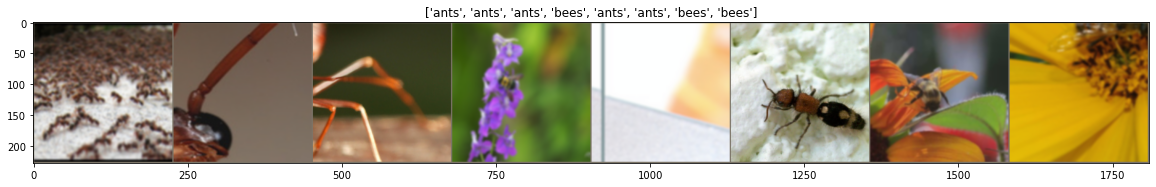

In [3]:
def imshow(inp, title=None, add_noise=False):
    """Imshow for Tensor."""
    if add_noise:
        fig = plt.figure(figsize=(20,16))
        inp = inp.numpy().transpose((1, 2, 0))
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        inp = std * inp + mean
        inp = np.clip(inp, 0, 1)
        plt.imshow(inp)
        if title is not None:
            plt.title(title)
        plt.pause(0.001)  # pause a bit so that plots are updated
    else:
        fig = plt.figure(figsize=(20,16))
        inp = inp.numpy().transpose((1, 2, 0))
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        inp = std * inp + mean
        inp = np.clip(inp, 0, 1)
        plt.imshow(inp)
        if title is not None:
            plt.title(title)
        plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes], add_noise=False)

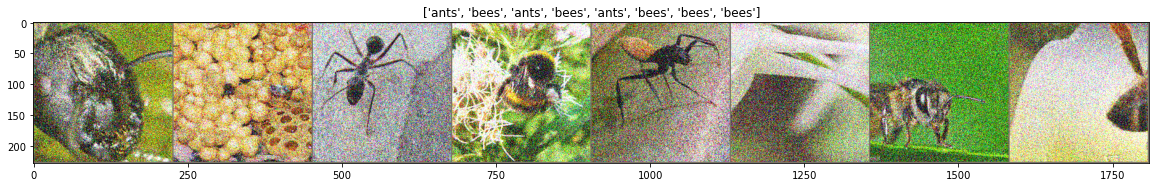

In [4]:
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean
        
    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean
    
    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

data_dir = '../Datasets/hymenoptera_data'
BATCH_SIZE = 8
NUM_WORKERS = 0

# Training parameters
NUM_EPOCHS = 15

# Initial set up for data loading

# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        AddGaussianNoise(0.5, 1)
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        AddGaussianNoise(0.5, 1)
    ]),
}

# dictionary of train and val datasets
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), transform=data_transforms[x]) for x in ['train', 'val']}

# dict of dataloaders, dataset sizes
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS) for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

class_names = image_datasets['train'].classes

# Set device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes], add_noise=False)

### Model Architecture

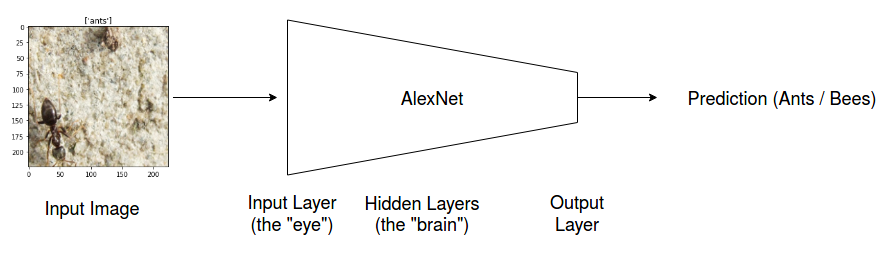

In [5]:
IPython.display.display(Image.open('../../PaperFigures/AlexNet.png'))

### Load Model

In [6]:
image_model = models.alexnet(pretrained=True)
image_model.load_state_dict(torch.load('../alexnet_finetuned.pt'))
image_model.cuda()

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

### Obtain Model Outputs

In [7]:
predictions = []
gt = []

image_model.eval()
for data, label in dataloaders['val']:
    data = data.type(torch.FloatTensor).cuda()
    label = label.long().cuda()

    outputs = image_model(data) # get outputs

    # Predictions
    _, predicted = torch.max(outputs.data, 1)
    predictions += list(np.array(predicted.cpu()).ravel())
    gt += list(np.array(label.cpu()).ravel())
    
print(list(zip(predictions, gt))[:50])  # show the first 50 (prediction, ground truth)

[(1, 0), (0, 0), (1, 1), (1, 1), (0, 0), (0, 1), (0, 0), (1, 0), (0, 0), (1, 1), (1, 1), (1, 1), (0, 0), (0, 1), (1, 1), (0, 0), (1, 1), (1, 0), (1, 0), (0, 0), (0, 0), (0, 0), (0, 1), (0, 0), (0, 1), (0, 1), (0, 0), (1, 0), (0, 0), (1, 1), (1, 0), (1, 1), (0, 0), (0, 1), (1, 1), (0, 0), (1, 0), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 0), (0, 0), (0, 0), (1, 0), (0, 0), (1, 1), (1, 1)]


### Pruning Demo

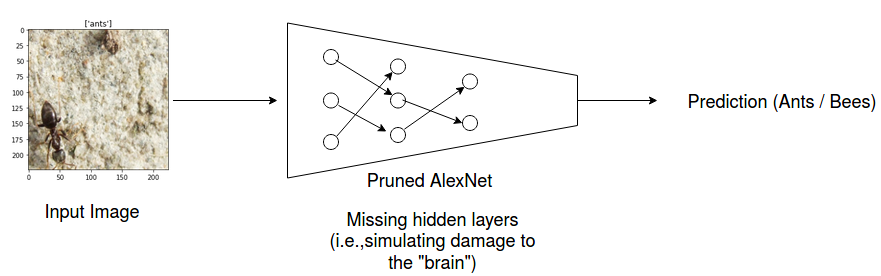

In [8]:
IPython.display.display(Image.open('../../PaperFigures/AlexNet_Pruned.png'))

In [9]:
from collections.abc import Iterable
import torch.nn.utils.prune as prune

def get_prunable_modules(model):
    modules = nn.Sequential(*list(model.children()))
    print(modules)

    # print(modules)
    parameters_to_prune = (
      (modules[0][0], 'weight'),
      (modules[0][3], 'weight'),
      (modules[0][6], 'weight'),
      (modules[0][8], 'weight'),
      (modules[0][10], 'weight'),

      (modules[2][1], 'weight'),
      (modules[2][4], 'weight'),
      (modules[2][6], 'weight')
        )

    modules_pruned = (
      (modules[0][0]),
      (modules[0][3]),
      (modules[0][6]),
      (modules[0][8]),
      (modules[0][10]),

      (modules[2][1]),
      (modules[2][4]),
      (modules[2][6])
        )

    return parameters_to_prune, modules_pruned

def do_pruning(pruned_model, value = 0.35):
    parameters_to_prune, modules_to_prune = get_prunable_modules(image_model)
    print(parameters_to_prune)

    prune.global_unstructured(
        parameters_to_prune,
        pruning_method=prune.L1Unstructured,
        amount=value)

    for m in modules_to_prune:
        prune.remove(m, 'weight')

    return pruned_model

prune_percentage = 0.35  # specify the pruning percentage
pruned_model = image_model

pruned_model = do_pruning(pruned_model, prune_percentage)

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (1): AdaptiveAvgPool2d(output_size=(6, 6))
  (2): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
    (2): ReLU(inplac

In [10]:
pruned_model

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

# Demo Audio Data Model

## Raw Audio Model

### Define Dataset

In [11]:
# Get dataset
class_dict = {'siren': 0,
             'jackhammer': 1,
             'air_conditioner': 2,
             'drilling': 3,
             'children_playing': 4,
             'street_music': 5,
             'dog_bark': 6,
             'engine_idling': 7,
             'gun_shot': 8,
             'car_horn': 9}

class SoundDataset(Dataset):
    def __init__(self, data_dir):
        self.sample_list = []
        
        for filename in os.listdir(data_dir):
            data, samplerate = librosa.load(f'{data_dir}/{filename}')
            label = int(filename.split('-')[0][-1])
            self.sample_list.append((label, torch.tensor(data), filename))
    
    def __len__(self):
        return len(self.sample_list)
    
    def __getitem__(self, idx):
        return self.sample_list[idx]

### Load Dataset for Demo

In [12]:
demoset_clean = SoundDataset('../Datasets/test/Raw')
demoset_noisy = SoundDataset('../Datasets/test/NoisyRaw')

### Audio Data Demo

In [13]:
print(demoset_clean[100])  # each sample has the label, the data, and the filename
print()
print(demoset_clean[100][1])  # here is an audio sample itself

(0, tensor([0.0444, 0.0501, 0.0133,  ..., 0.0435, 0.0330, 0.0163]), 'class0-fold5-111671-8-0-3.wav')

tensor([0.0444, 0.0501, 0.0133,  ..., 0.0435, 0.0330, 0.0163])


#### Clean Audio

In [14]:
print('Clean Siren')
IPython.display.Audio(demoset_clean[100][1], rate=22050)

Clean Siren


In [15]:
print('Noisy Siren')
IPython.display.Audio(demoset_noisy[100][1], rate=22050)

Noisy Siren


In [16]:
print('Clean Jackhammer')
IPython.display.Audio(demoset_clean[200][1], rate=22050)

Clean Jackhammer


In [17]:
print('Noisy Jackhammer')
IPython.display.Audio(demoset_noisy[200][1], rate=22050)

Noisy Jackhammer


### Define Model Architecture

In [18]:
class AudioNet(nn.Module):  #1D convolutions
    def __init__(self, num_classes):
        super(AudioNet, self).__init__()
        
        self.conv1 = nn.Conv1d(1, 16, kernel_size=23, stride=5, padding=0) #try making kernels larger, fewer layers, less maxp
        self.batchnorm1 = nn.BatchNorm1d(16)
        self.conv2 = nn.Conv1d(16, 32, kernel_size=7, stride=3, padding=0)
        self.batchnorm2 = nn.BatchNorm1d(32)
        self.lrelu = nn.LeakyReLU()
        self.max2 = nn.MaxPool1d(kernel_size=3)
        self.conv3 = nn.Conv1d(32, 64, kernel_size=5, stride=3, padding=0)
        self.batchnorm3 = nn.BatchNorm1d(64)
        self.drop1 = nn.Dropout(p=0.5)
        self.max3 = nn.MaxPool1d(kernel_size=3)
        self.conv4 = nn.Conv1d(64, 64, kernel_size=5, stride=3, padding=0)
        self.batchnorm4 = nn.BatchNorm1d(64)
        self.conv5 = nn.Conv1d(64, 64, kernel_size=7, stride=3, padding=0)
        self.fc1 = nn.Linear(64 * 22, 64)
        self.fc2 = nn.Linear(64, num_classes)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.batchnorm1(x)
        x = self.conv2(x)
        x = self.batchnorm2(x)
        x = self.lrelu(x)
        x = self.max2(x)
        x = self.conv3(x)
        x = self.batchnorm3(x)
        x = self.drop1(x)
        x = self.max3(x)
        x = self.conv4(x)
        x = self.batchnorm4(x)
        x = self.conv5(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        out = self.fc2(x)
        return out

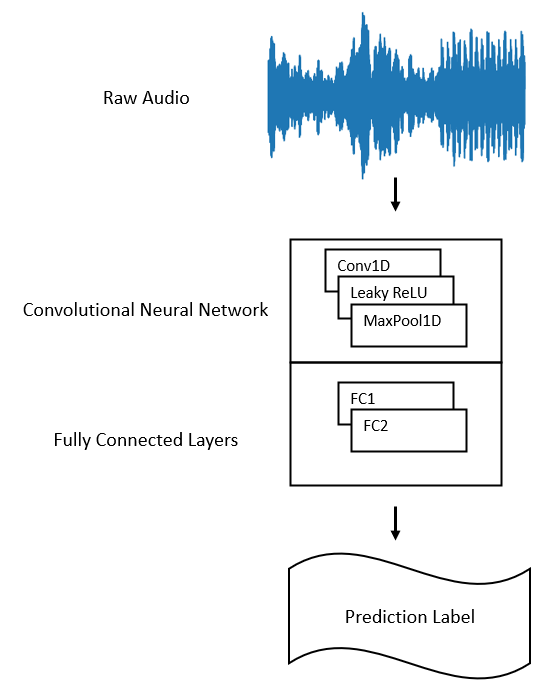

In [19]:
IPython.display.display(Image.open('../../PaperFigures/RawAudio_Model.png'))

### Load Trained Model

In [20]:
model = AudioNet(num_classes=9)
model.load_state_dict(torch.load('models/audio_net.pt'))
model.cuda()

AudioNet(
  (conv1): Conv1d(1, 16, kernel_size=(23,), stride=(5,))
  (batchnorm1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv1d(16, 32, kernel_size=(7,), stride=(3,))
  (batchnorm2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (lrelu): LeakyReLU(negative_slope=0.01)
  (max2): MaxPool1d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv1d(32, 64, kernel_size=(5,), stride=(3,))
  (batchnorm3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (drop1): Dropout(p=0.5, inplace=False)
  (max3): MaxPool1d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv1d(64, 64, kernel_size=(5,), stride=(3,))
  (batchnorm4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv1d(64, 64, kernel_size=(7,), stride=(3,))
  (fc1): Linear(in_features=1408, out_features=64, bias=True)
  (fc2

### Obtain Model Outputs

In [21]:
demo_loader = DataLoader(dataset = demoset_clean,
                      batch_size = 32,
                      shuffle = False)
predictions = []
gt = []

model.eval()
for i, (label, data, _) in enumerate(demo_loader):
    data = data.type(torch.FloatTensor).cuda().unsqueeze(1)
    label = label.long().cuda()

    outputs = model(data) # get outputs

    # Predictions
    _, predicted = torch.max(outputs.data, 1)
    predictions += list(np.array(predicted.cpu()).ravel())
    gt += list(np.array(label.cpu()).ravel())
    
print(list(zip(predictions, gt))[:50])  # show the first 50 (prediction, ground truth)

[(4, 0), (4, 0), (4, 0), (0, 0), (0, 0), (0, 0), (4, 0), (4, 0), (0, 0), (0, 0), (4, 0), (0, 0), (4, 0), (4, 0), (4, 0), (4, 0), (4, 0), (4, 0), (0, 0), (0, 0), (0, 0), (0, 0), (4, 0), (4, 0), (4, 0), (4, 0), (4, 0), (4, 0), (0, 0), (1, 0), (4, 0), (4, 0), (0, 0), (0, 0), (0, 0), (4, 0), (0, 0), (4, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0)]


## Spectrogram-based Audio Model

### Define Dataset

In [22]:
# Get spect_dataset
class SpectDataset(Dataset):
    def __init__(self, data_dir):
        self.sample_list = []
        
        for filename in os.listdir(data_dir):
            image = plt.imread(f'{data_dir}/{filename}')[:,:,0]
            label = int(filename.split('-')[0][-1])
            self.sample_list.append((label, torch.tensor(image), filename)) #class_label, data, filename
                
    
    def __len__(self):
        return len(self.sample_list)
    
    def __getitem__(self, idx):
        return self.sample_list[idx]

### Load Dataset

In [23]:
# Load the data (spectrogram)
demoset_clean_spect = SpectDataset('../Datasets/test/Spectrograms')
demoset_noisy_raw_spect = SpectDataset('../Datasets/test/NoisyRawSpectrograms')
demoset_noisy_spect = SpectDataset('../Datasets/test/NoisySpectrograms')

### Spectrogram Data Demo (Log Spectrograms)

In [24]:
print(demoset_clean_spect[0])  # each sample has the label, the data, and the filename
print()
print(demoset_clean_spect[0][1])  # here is an audio sample itself

(0, tensor([[0.0235, 0.0157, 0.0157,  ..., 0.0039, 0.0039, 0.0000],
        [0.0549, 0.0275, 0.0314,  ..., 0.0078, 0.0078, 0.0039],
        [0.0039, 0.0039, 0.0078,  ..., 0.0078, 0.0000, 0.0039],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]]), 'class0-fold1-118279-8-0-11-Spectrogram.png')

tensor([[0.0235, 0.0157, 0.0157,  ..., 0.0039, 0.0039, 0.0000],
        [0.0549, 0.0275, 0.0314,  ..., 0.0078, 0.0078, 0.0039],
        [0.0039, 0.0039, 0.0078,  ..., 0.0078, 0.0000, 0.0039],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]])


Text(0.5, 1.0, 'Clean Siren')

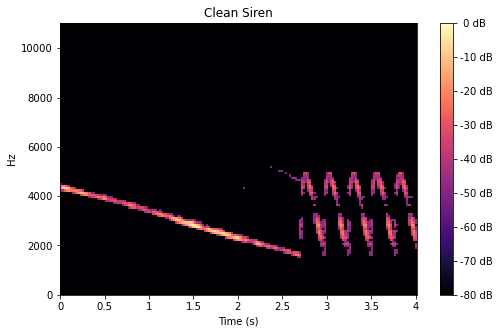

In [25]:
fig = plt.figure(figsize=(8,5))
sample = demoset_clean_spect[100]
spect = sample[1]
class_name = 'Clean Siren'
spect = spect.numpy()
spect_db = librosa.power_to_db(spect**2)
librosa.display.specshow(spect_db, sr=22050, x_axis='time', y_axis='linear')
plt.colorbar(format='%2.0f dB')
plt.xlabel('Time (s)')
plt.title(f'{class_name}')

Text(0.5, 1.0, 'Noisy Raw Siren')

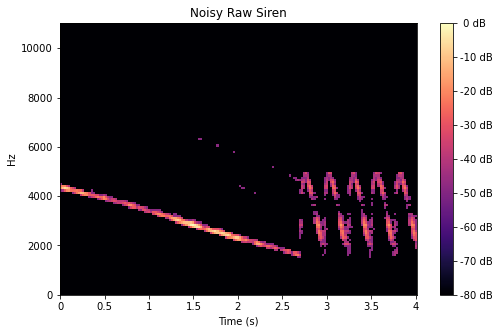

In [26]:
fig = plt.figure(figsize=(8,5))
sample = demoset_noisy_raw_spect[100]
spect = sample[1]
class_name = 'Noisy Raw Siren'
spect = spect.numpy()
spect_db = librosa.power_to_db(spect**2)
librosa.display.specshow(spect_db, sr=22050, x_axis='time', y_axis='linear')
plt.colorbar(format='%2.0f dB')
plt.xlabel('Time (s)')
plt.title(f'{class_name}')

Text(0.5, 1.0, 'Noisy Siren')

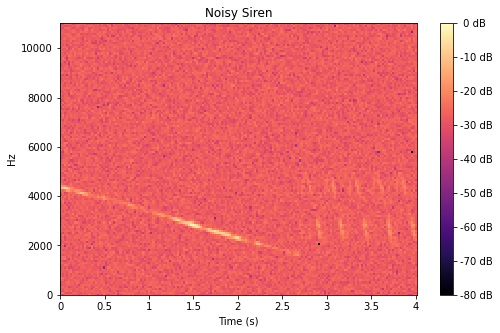

In [27]:
fig = plt.figure(figsize=(8,5))
sample = demoset_noisy_spect[100]
spect = sample[1]
class_name = 'Noisy Siren'
spect = spect.numpy()
spect_db = librosa.power_to_db(spect**2)
librosa.display.specshow(spect_db, sr=22050, x_axis='time', y_axis='linear')
plt.colorbar(format='%2.0f dB')
plt.xlabel('Time (s)')
plt.title(f'{class_name}')

Text(0.5, 1.0, 'Clean Jackhammer')

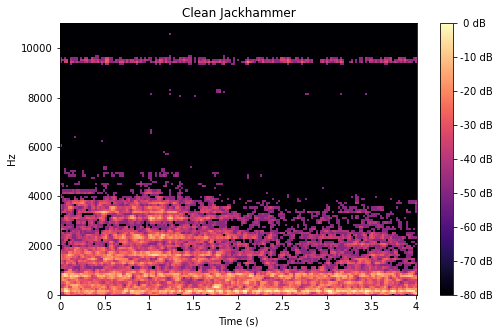

In [28]:
fig = plt.figure(figsize=(8,5))
sample = demoset_clean_spect[200]
spect = sample[1]
class_name = 'Clean Jackhammer'
spect = spect.numpy()
spect_db = librosa.power_to_db(spect**2)
librosa.display.specshow(spect_db, sr=22050, x_axis='time', y_axis='linear')
plt.colorbar(format='%2.0f dB')
plt.xlabel('Time (s)')
plt.title(f'{class_name}')

Text(0.5, 1.0, 'Noisy Raw Jackhammer')

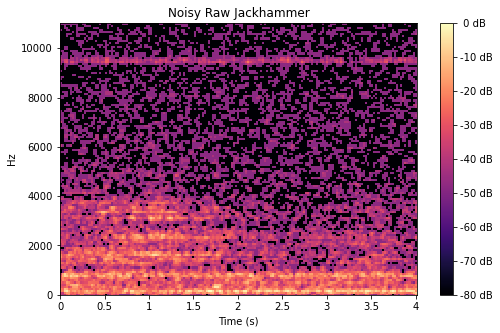

In [29]:
fig = plt.figure(figsize=(8,5))
sample = demoset_noisy_raw_spect[200]
spect = sample[1]
class_name = 'Noisy Raw Jackhammer'
spect = spect.numpy()
spect_db = librosa.power_to_db(spect**2)
librosa.display.specshow(spect_db, sr=22050, x_axis='time', y_axis='linear')
plt.colorbar(format='%2.0f dB')
plt.xlabel('Time (s)')
plt.title(f'{class_name}')

Text(0.5, 1.0, 'Noisy Jackhammer')

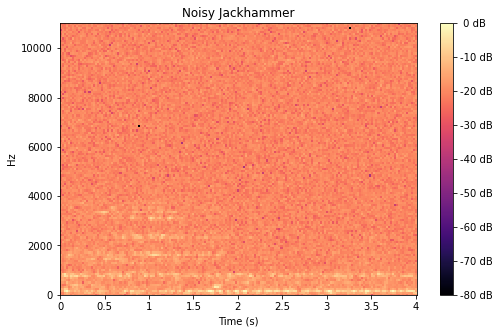

In [30]:
fig = plt.figure(figsize=(8,5))
sample = demoset_noisy_spect[200]
spect = sample[1]
class_name = 'Noisy Jackhammer'
spect = spect.numpy()
spect_db = librosa.power_to_db(spect**2)
librosa.display.specshow(spect_db, sr=22050, x_axis='time', y_axis='linear')
plt.colorbar(format='%2.0f dB')
plt.xlabel('Time (s)')
plt.title(f'{class_name}')

### Define Model Architecture

In [31]:
class AudioNetSpect(nn.Module):  #2D convolutions on spectrograms
    def __init__(self, num_classes):
        super(AudioNetSpect, self).__init__()
        
        self.conv1 = nn.Conv2d(1, 16, kernel_size=7, stride=1, padding=0) #try making kernels larger, fewer layers, less maxp
        self.batchnorm1 = nn.BatchNorm2d(16)
        self.drop1 = nn.Dropout(p=0.5)
        self.lrelu1 = nn.LeakyReLU()
        self.max1 = nn.MaxPool2d(kernel_size=3)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=0)
        self.batchnorm2 = nn.BatchNorm2d(32)
        self.drop2 = nn.Dropout(p=0.5)
        self.lrelu2 = nn.LeakyReLU()
        self.max2 = nn.MaxPool2d(kernel_size=3)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=0)
        self.batchnorm3 = nn.BatchNorm2d(64)
        self.fc1 = nn.Linear(64 * 8 * 13, 128)
        self.fc2 = nn.Linear(128, num_classes)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.batchnorm1(x)
        x = self.drop1(x)
        x = self.lrelu1(x)
        x = self.max1(x)
        x = self.conv2(x)
        x = self.batchnorm2(x)
        x = self.drop2(x)
        x = self.lrelu2(x)
        x = self.max2(x)
        x = self.conv3(x)
        x = self.batchnorm3(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        out = self.fc2(x)
        return out

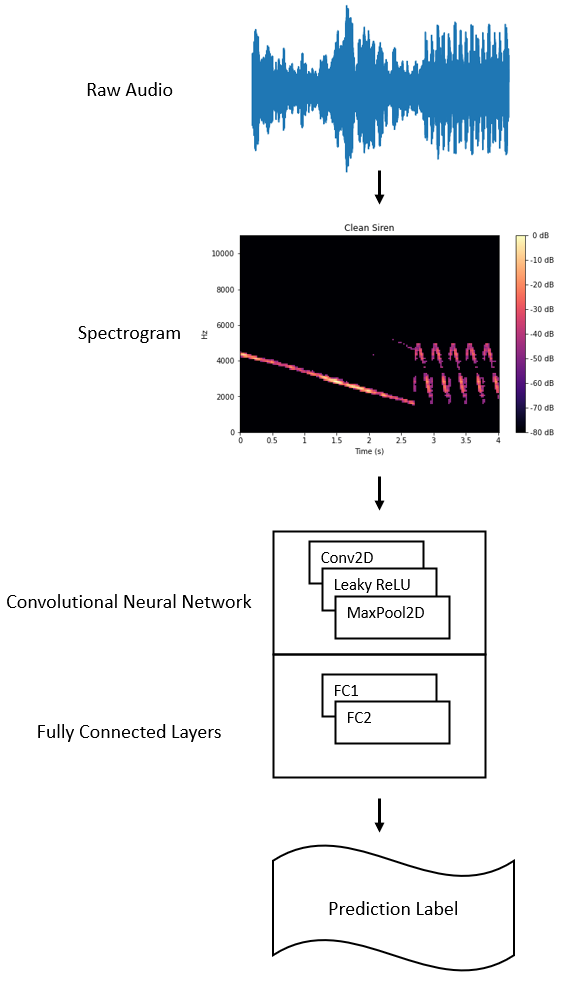

In [32]:
IPython.display.display(Image.open('../../PaperFigures/Spectrogram_Model.png'))

### Load Trained Model

In [33]:
# Load model
model = AudioNetSpect(num_classes=9)
model.load_state_dict(torch.load('models/audio_net_spect.pt'))
model.cuda()

AudioNetSpect(
  (conv1): Conv2d(1, 16, kernel_size=(7, 7), stride=(1, 1))
  (batchnorm1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (drop1): Dropout(p=0.5, inplace=False)
  (lrelu1): LeakyReLU(negative_slope=0.01)
  (max1): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (batchnorm2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (drop2): Dropout(p=0.5, inplace=False)
  (lrelu2): LeakyReLU(negative_slope=0.01)
  (max2): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (batchnorm3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=6656, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=9, bias=True)
)

### Obtain Model Outputs

In [34]:
demo_loader = DataLoader(dataset = demoset_clean_spect,
                      batch_size = 32,
                      shuffle = False)
predictions = []
gt = []

model.eval()
for i, (label, data, _) in enumerate(demo_loader):
    data = data.type(torch.FloatTensor).cuda().unsqueeze(1)
    label = label.long().cuda()

    outputs = model(data) # get outputs

    # Predictions
    _, predicted = torch.max(outputs.data, 1)
    predictions += list(np.array(predicted.cpu()).ravel())
    gt += list(np.array(label.cpu()).ravel())
    
print(list(zip(predictions, gt))[:50])  # show the first 50 (prediction, ground truth)

[(1, 0), (1, 0), (0, 0), (0, 0), (4, 0), (0, 0), (2, 0), (6, 0), (4, 0), (0, 0), (1, 0), (1, 0), (7, 0), (2, 0), (2, 0), (4, 0), (1, 0), (0, 0), (0, 0), (0, 0), (7, 0), (0, 0), (4, 0), (0, 0), (4, 0), (1, 0), (1, 0), (1, 0), (0, 0), (1, 0), (4, 0), (1, 0), (1, 0), (0, 0), (4, 0), (0, 0), (4, 0), (4, 0), (5, 0), (0, 0), (4, 0), (0, 0), (0, 0), (0, 0), (0, 0), (1, 0), (0, 0), (1, 0), (0, 0), (1, 0)]


### Visualization of detailed model architecture

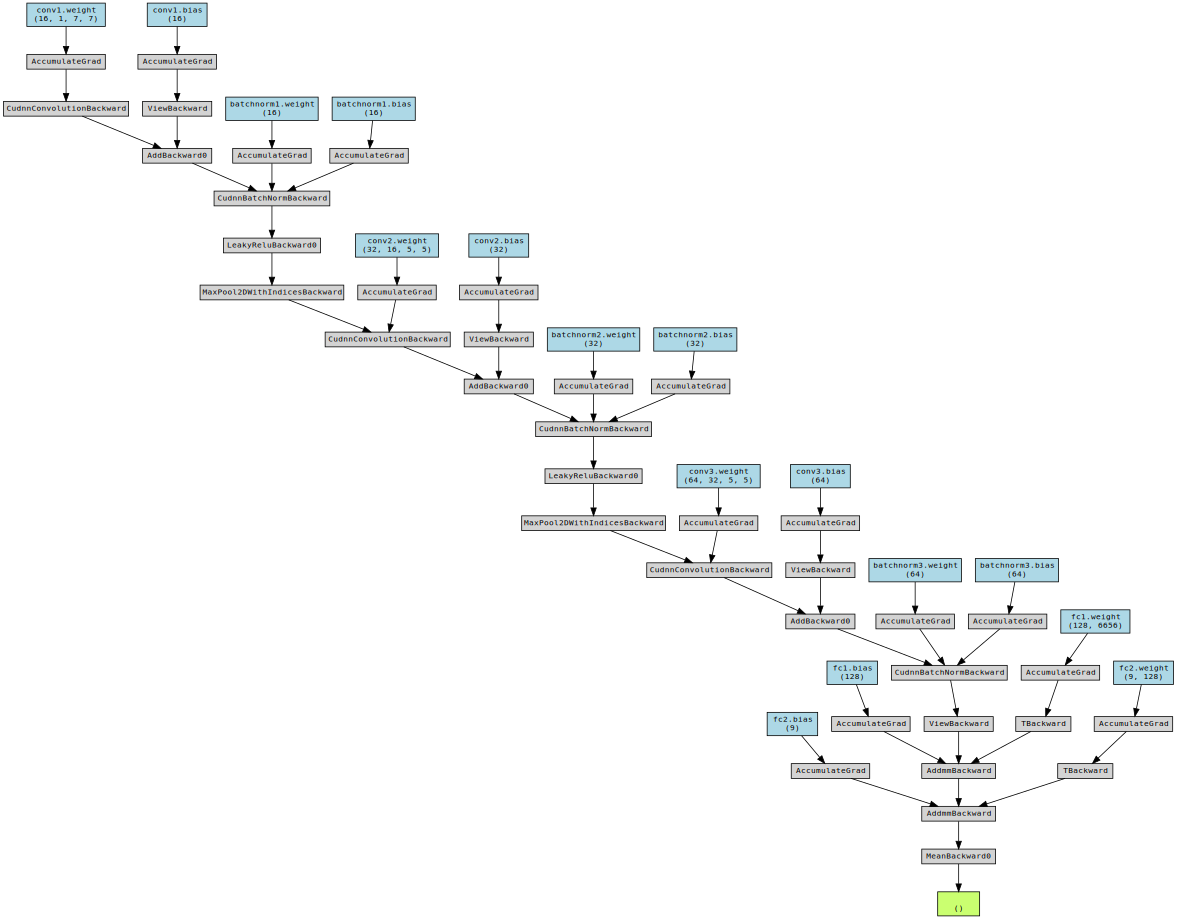

In [35]:
torchviz.make_dot(outputs.mean(), params=dict(model.named_parameters()))

### Pruning Demo

In [36]:
from collections.abc import Iterable
import torch.nn.utils.prune as prune

def get_prunable_modules(model):
    modules = nn.Sequential(*list(model.children()))
    print(modules)

    # print(modules)
    parameters_to_prune = (
        (modules[0], 'weight'),
        (modules[5], 'weight'),
        (modules[10], 'weight')
        )

    modules_pruned = (
        (modules[0]),
        (modules[5]),
        (modules[10])
        )

    return parameters_to_prune, modules_pruned

def do_pruning(pruned_model, value = 0.35):
    parameters_to_prune, modules_to_prune = get_prunable_modules(model)
    print(parameters_to_prune)

    prune.global_unstructured(
        parameters_to_prune,
        pruning_method=prune.L1Unstructured,
        amount=value)

    for m in modules_to_prune:
        prune.remove(m, 'weight')

    return pruned_model

prune_percentage = 0.35  # specify the pruning percentage
pruned_model = model

pruned_model = do_pruning(pruned_model, prune_percentage)

Sequential(
  (0): Conv2d(1, 16, kernel_size=(7, 7), stride=(1, 1))
  (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): LeakyReLU(negative_slope=0.01)
  (4): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (6): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): Dropout(p=0.5, inplace=False)
  (8): LeakyReLU(negative_slope=0.01)
  (9): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (11): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (12): Linear(in_features=6656, out_features=128, bias=True)
  (13): Linear(in_features=128, out_features=9, bias=True)
)
((Conv2d(1, 16, kernel_size=(7, 7), stride=(1, 1)), 'weight'), (Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1)), 'we

In [37]:
pruned_model

AudioNetSpect(
  (conv1): Conv2d(1, 16, kernel_size=(7, 7), stride=(1, 1))
  (batchnorm1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (drop1): Dropout(p=0.5, inplace=False)
  (lrelu1): LeakyReLU(negative_slope=0.01)
  (max1): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (batchnorm2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (drop2): Dropout(p=0.5, inplace=False)
  (lrelu2): LeakyReLU(negative_slope=0.01)
  (max2): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (batchnorm3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=6656, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=9, bias=True)
)